# ADF Test (adfuller)

Augmented Dickey-Fuller Test → checks stationarity of a time series.

Stationary series is required for ARIMA and many forecasting models.
# PACF (Partial Autocorrelation Function)

Shows correlation of a time series with its lags, controlling for shorter lags.

Used to determine the p (AR term) in ARIMA models.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
sns.set_context("paper", font_scale=1.3)

from time import time 
import matplotlib.ticker as tkr 
from scipy import stats 
from statsmodels.tsa.stattools import adfuller,pacf 
import math 

import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

import warnings 
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('household_power_consumption.txt',delimiter=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0



The data is the measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available. However, we are only interested in Global_active_power variable.

In [3]:
print('Number of rows and columns in dataset:',df.shape)

Number of rows and columns in dataset: (2075259, 9)


### Exploratory data analysis(EDA)

In [4]:
df.describe(include='all')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2.049280e+06
unique,1442,1440,6534,896,5168,377,153,145,NaN
top,6/12/2008,17:24:00,?,0.000,?,1.000,0.000,0.000,NaN
freq,1440,1442,25979,472786,25979,169406,1840611,1408274,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.458447e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.437154e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.700000e+01


In [5]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Approximately 1.2% of the Global_active_power values are missing, which is a negligible amount,therefore i decided to drop them.

In [6]:
df['date_tim']=pd.to_datetime(df['Date']+ ' '+df['Time'])
df['Global_active_power']=pd.to_numeric(df['Global_active_power'],errors='coerce')
df=df.dropna(subset=['Global_active_power'])

In [7]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,date_tim
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [8]:
df['date_time']=pd.to_datetime(df['date_tim']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df.head()

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.216,2006,4,12,16
1,2006-12-16 17:25:00,5.360,2006,4,12,16
2,2006-12-16 17:26:00,5.374,2006,4,12,16
3,2006-12-16 17:27:00,5.388,2006,4,12,16
4,2006-12-16 17:28:00,3.666,2006,4,12,16


In [9]:
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,5
1,2006-12-16 17:25:00,5.360,2006,4,12,16,5
2,2006-12-16 17:26:00,5.374,2006,4,12,16,5
3,2006-12-16 17:27:00,5.388,2006,4,12,16,5
4,2006-12-16 17:28:00,3.666,2006,4,12,16,5


In [10]:
df['weekday']= (df['weekday']<5).astype(int)
df.head()

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0


In [11]:
print(df.shape) 
print(df.date_time.min())
print(df.date_time.max())

(2049280, 7)
2006-12-16 17:24:00
2010-11-26 21:02:00


In [12]:
df.tail()

,date_time,Global_active_power,year,quarter,month,day,weekday
2049275,2010-11-26 20:58:00,0.946,2010,4,11,26,1
2049276,2010-11-26 20:59:00,0.944,2010,4,11,26,1
2049277,2010-11-26 21:00:00,0.938,2010,4,11,26,1
2049278,2010-11-26 21:01:00,0.934,2010,4,11,26,1
2049279,2010-11-26 21:02:00,0.932,2010,4,11,26,1


In [13]:
print('Dataset shape after removing missing values:',df.shape)
print('time series starts from: ',df.date_time.min())
print('time series ends at: ',df.date_time.max())

Dataset shape after removing missing values: (2049280, 7)
time series starts from:  2006-12-16 17:24:00
time series ends at:  2010-11-26 21:02:00


The dataset includes multiple variables, but our analysis will concentrate on a single one: the household’s Global_active_power, which represents the minute-averaged active power consumption (in kilowatts).

### Statistical Normality Test
To check whether the data follows a Gaussian (normal) distribution, we can apply statistical normality tests. In this case, we use D’Agostino’s K² test.

In SciPy’s implementation, the test returns a p-value, which we interpret as:

- If p ≤ α (significance level), we reject the null hypothesis → the data is not normally distributed.

- If p > α, we fail to reject the null hypothesis → the data can be considered normally distributed.

In [14]:
stat, p=stats.normaltest(df.Global_active_power)
print('statistics=%.3f, p=%.3f' % (stat,p))

if p >0.05: 
    print('Data looks Gaussian (failed to reject null hypothesis(H0')
else:
    print('Data does not look Gaussian (reject null hypothesis(H0))')

statistics=724881.795, p=0.000
Data does not look Gaussian (reject null hypothesis(H0))


we can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution 

### KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

### SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

Kurtosis of normal distribution: 4.218671866132123
Skewness of normal distribution: 1.7862320846320818


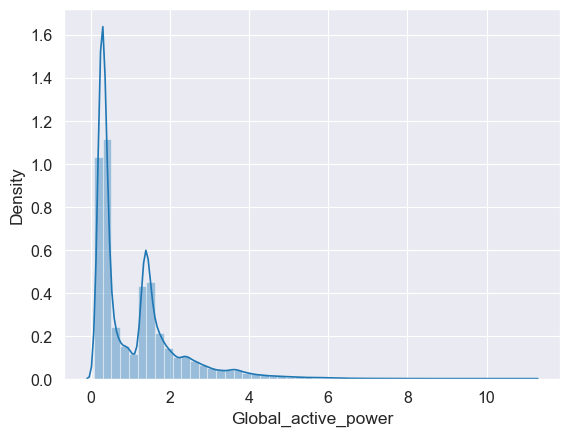

In [15]:
sns.distplot(df.Global_active_power)
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

## Series plot

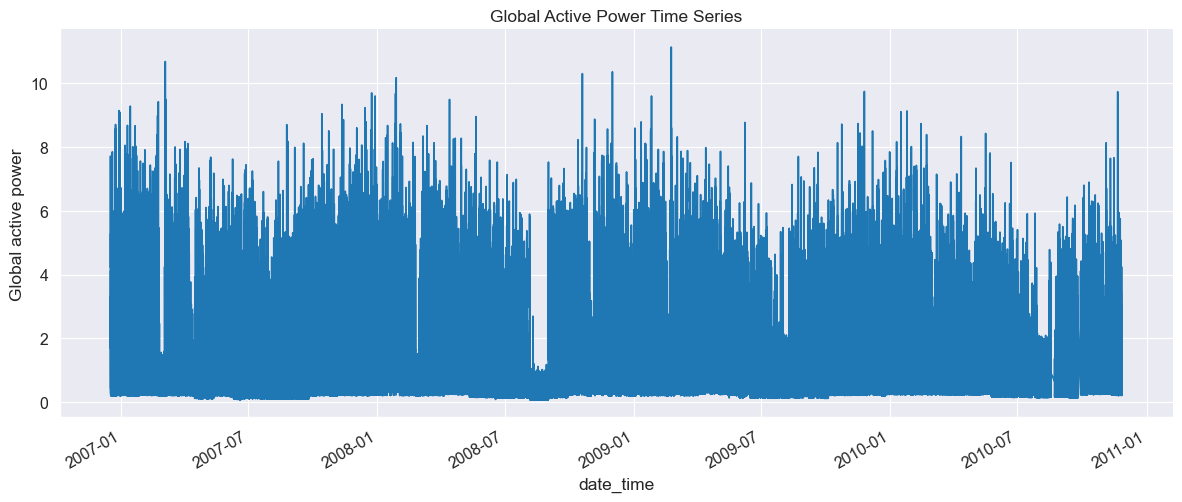

In [16]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();


### Box plot of yearly vs. quartely global active power 

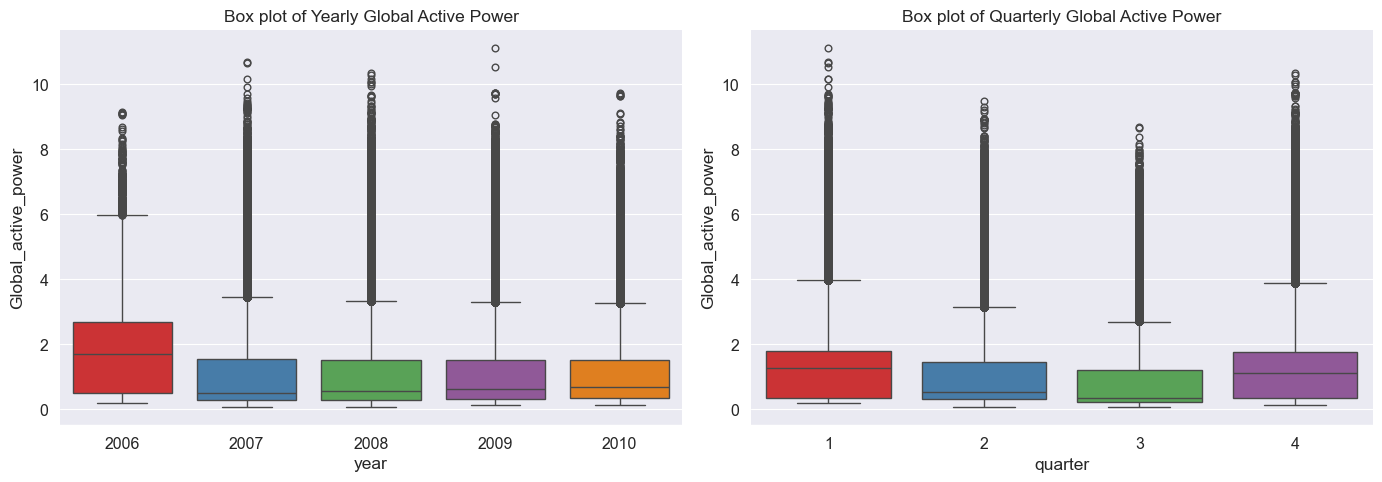

In [17]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df,palette='Set1')
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df,palette='Set1')
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout()

When we compare boxplot side by side for each year, we notice that the median global active power in 2006 is much higher than the other years'. This is a little bit misleading. If you remember, we only have December data for 2006. While apparently December is the peak month for household electric power consumption.

This is consistent with the quarterly median global active power, it is higher in the 1st and 4th quarters (winter), and it is the lowest in the 3rd quarter (summer).

### Global active power distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


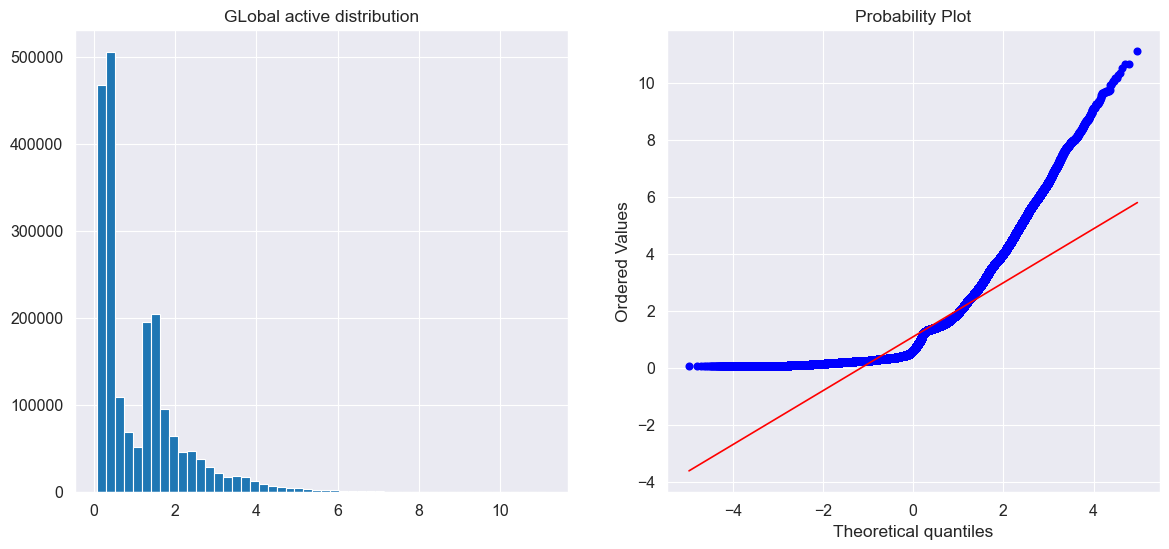

In [18]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('GLobal active distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'],plot=plt) 
df1.describe().T

Normal probability plot also shows the data set is far from normally distributed.

## Average Global Active Power resampled over day, week, month, quarter and year.

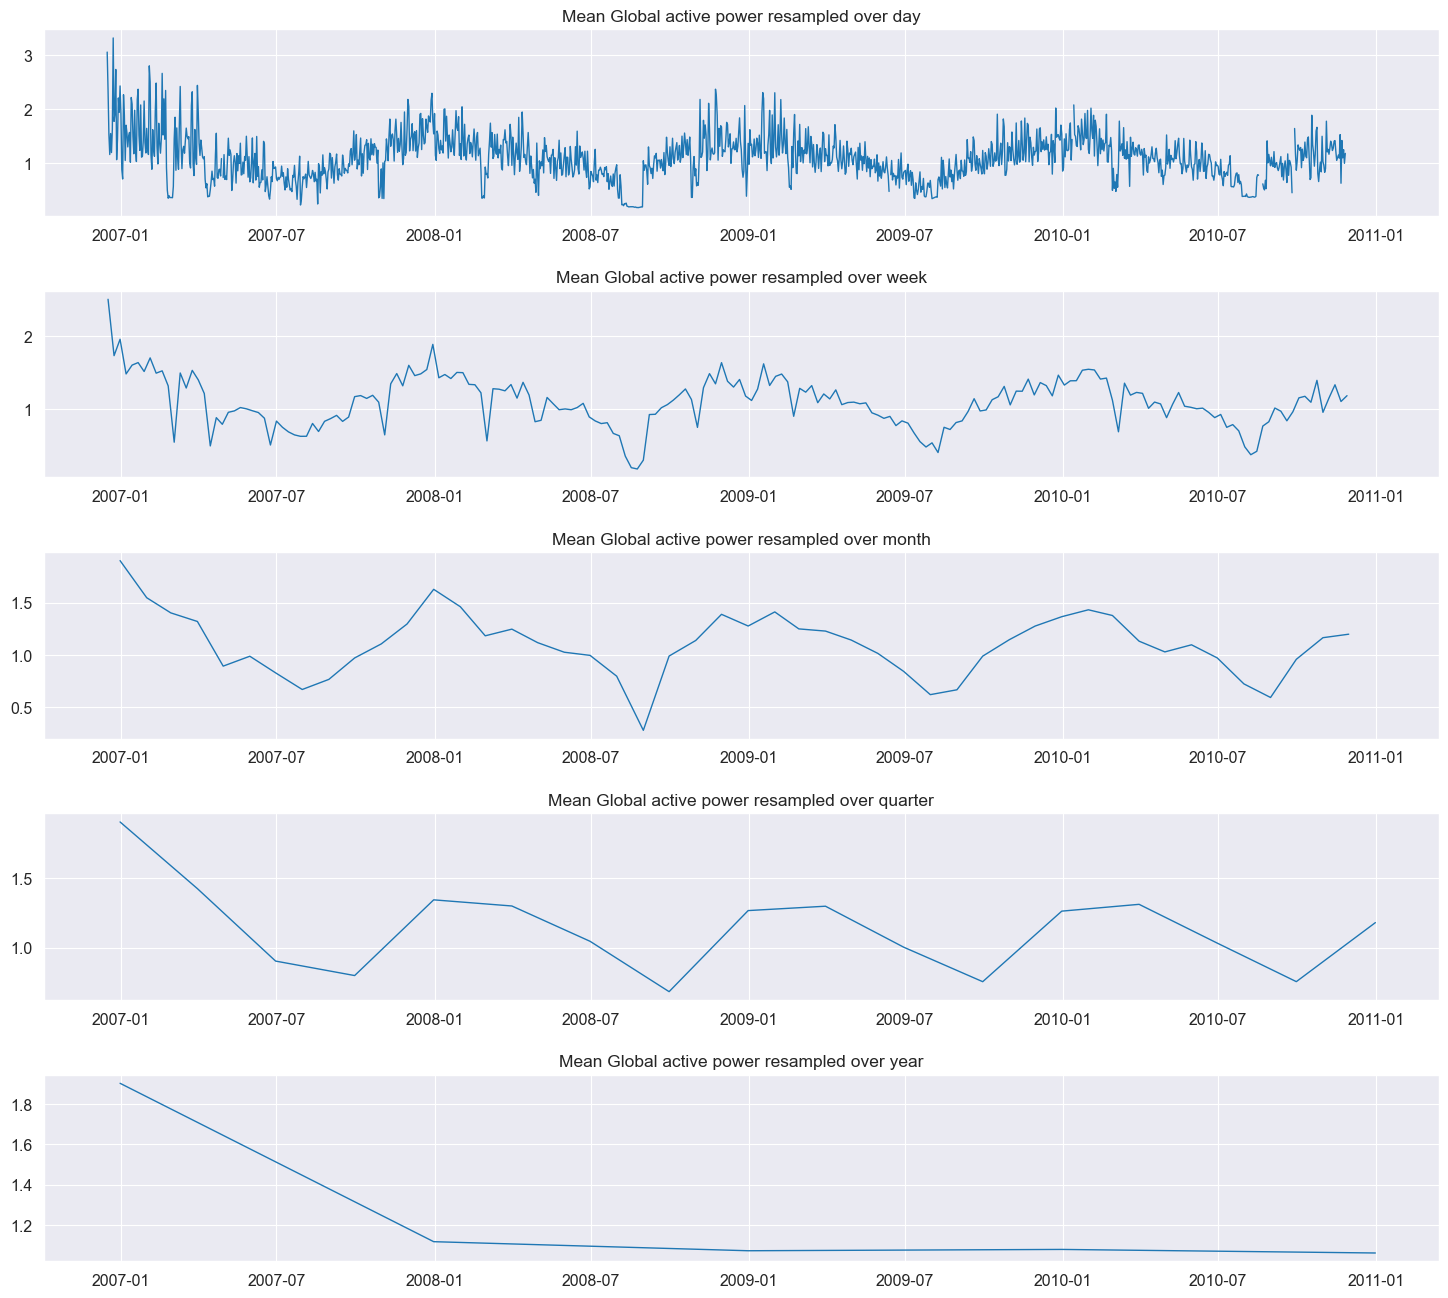

In [19]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major')

In general, our time series does not have a general upward or downward trend. The highest average power consumption was prior to 2007, it decreased significantly in one year until early 2008, and has been steady since then.

### Plot mean global active power grouped by year, quarter, month and day.

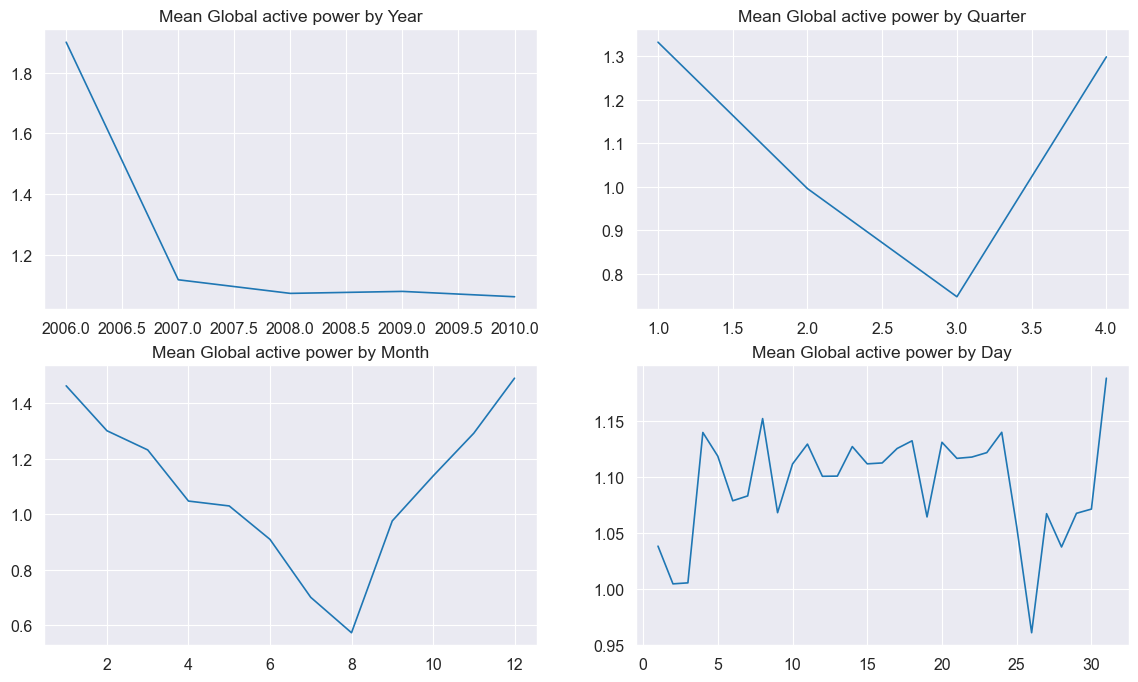

In [20]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day')
plt.show()

The above plots confirmed our previous discoveries. By year, the highest average power consumption was prior to 2007, and it has been consistent since then. By quarter, the lowest average power consumption was in the 3rd quarter. By month, the lowest average power consumption was in July and August. By day, the lowest average power consumption was around 8th of the month.

### Global active power by years
For 2006,we only have data for December, so remove 2006

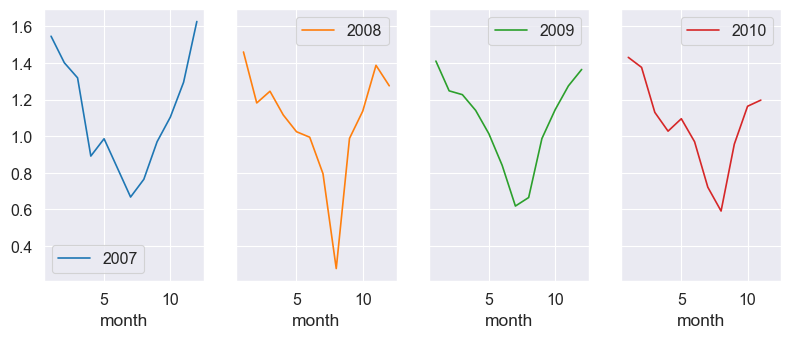

In [21]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

## Global active power consumption in Weekdays vs. Weekends

dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9,4)) 
plt1 = sns.boxplot(x='year', y='Global_active_power', hue='Day',
                   width=0.6, fliersize=3, data=df)                                                                                                                                                                                                                                                                                                                                                
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median global active power in weekdays seems to be lower than the weekends prior to 2010.

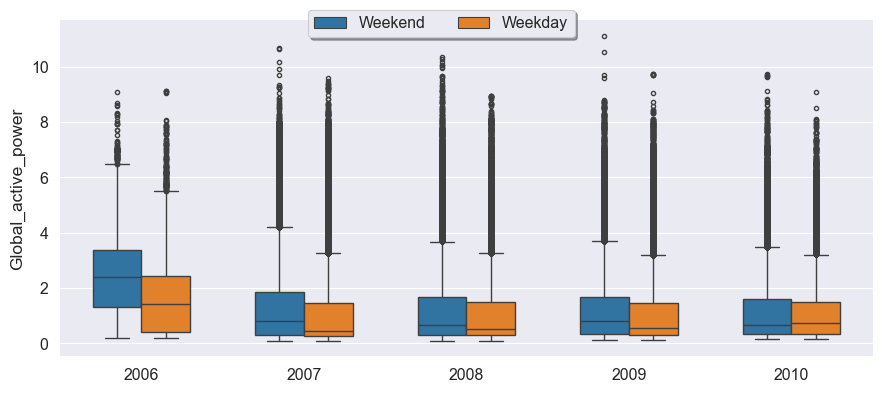

In [22]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot(x='year',y='Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False)


Both weekdays and weekends have the similar trends over year.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

## Dickey-Fuller Test to Check Stationarity
In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test
Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [23]:
df2=df1.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

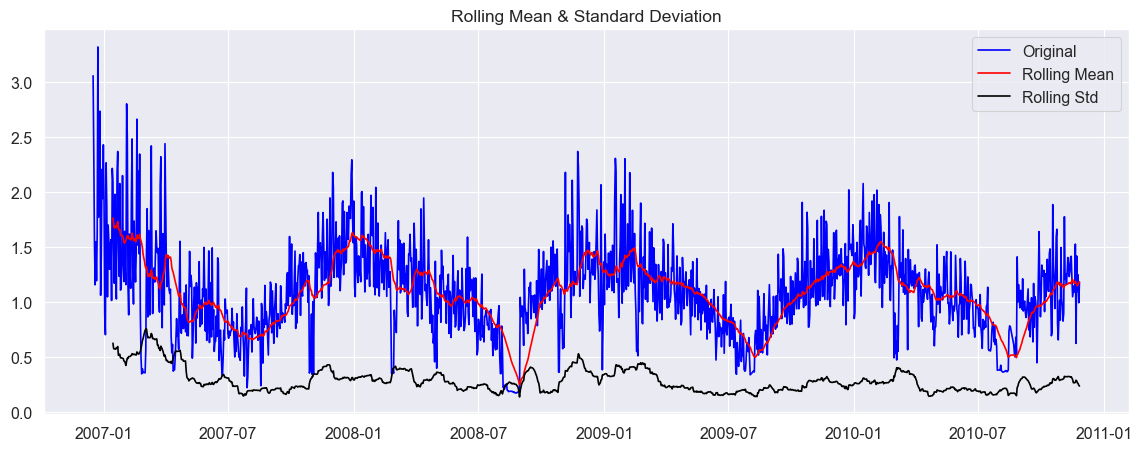

<Results of Dickey-Fuller Test>
Test Statistic                   -3.684228
p-value                           0.004341
#Lags Used                       22.000000
Number of Observations Used    1410.000000
Critical Value (1%)              -3.434996
Critical Value (5%)              -2.863592
Critical Value (10%)             -2.567862
dtype: float64


In [24]:
test_stationarity(df2.Global_active_power.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary 

## LSTM

The goal is to forecast future values in a time series using a dataset of 2 million minutes of household power consumption. To achieve this, we will build a multi-layer LSTM recurrent neural network that learns from sequences of past values to predict the next one.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minutes.

The process involves several steps: preparing the dataset, normalizing the values, splitting it into training and testing sets, and transforming the raw values into a structured matrix format suitable for the LSTM model.

In [25]:
dataset=df.Global_active_power.values 
dataset=dataset.astype('float32')
dataset=np.reshape(dataset,(-1,1))
scaler=StandardScaler()
dataset=scaler.fit_transform(dataset)


In [26]:
dataset

array([[ 2.9550772 ],
       [ 4.0370846 ],
       [ 4.050326  ],
       ...,
       [-0.14529073],
       [-0.14907399],
       [-0.15096565]], dtype=float32)

In [27]:
train_size=int(len(dataset)*0.80)
test_size=len(dataset)-train_size
train, test=dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [28]:
train.shape

(1639424, 1)

In [29]:
test.shape

(409856, 1)

In [30]:
#convert an array of values into a dataset matrix 
def create_dataset(dataset,look_back=1): 
    X,Y=[], []
    for i in range(len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        X.append(a) 
        Y.append(dataset[i + look_back,0])
    return np.array(X),np.array(Y)

In [31]:
# reshape into X=t and Y=t+1 
look_back=30
X_train,Y_train=create_dataset(train, look_back)
X_test,Y_test=create_dataset(test, look_back)

In [32]:
X_train.shape

(1639393, 30)

In [33]:
Y_train.shape

(1639393,)

In [34]:
# reshape input to be [samples, time_steps, features]
X_train=np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test=np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [35]:
X_train.shape

(1639393, 1, 30)

#### Model making

In [36]:
model=Sequential()

model.add(layers.LSTM(50,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                16200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,913
Trainable params: 27,913
Non-trainable params: 0
_________________________________________________________________


In [37]:
# model.compile()
tf.__version__

'2.10.1'

In [38]:
model.compile(loss='mse',optimizer='adam')

In [39]:
history=model.fit(X_train,Y_train,epochs=20,validation_data=[X_test,Y_test],
                 batch_size=70,callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)

Epoch 1/20
23420/23420 [==============================] - 78s 3ms/step - loss: 0.0923 - val_loss: 0.0546
Epoch 2/20
23420/23420 [==============================] - 76s 3ms/step - loss: 0.0787 - val_loss: 0.0627
Epoch 3/20
23420/23420 [==============================] - 77s 3ms/step - loss: 0.0745 - val_loss: 0.0666
Epoch 4/20
23420/23420 [==============================] - 77s 3ms/step - loss: 0.0716 - val_loss: 0.0695
Epoch 5/20
23420/23420 [==============================] - 77s 3ms/step - loss: 0.0700 - val_loss: 0.0770
Epoch 6/20
23420/23420 [==============================] - 78s 3ms/step - loss: 0.0686 - val_loss: 0.0744
Epoch 7/20
23420/23420 [==============================] - 77s 3ms/step - loss: 0.0678 - val_loss: 0.0780
Epoch 8/20
23420/23420 [==============================] - 77s 3ms/step - loss: 0.0669 - val_loss: 0.0767
Epoch 9/20
23420/23420 [==============================] - 78s 3ms/step - loss: 0.0665 - val_loss: 0.0783
Epoch 10/20
23420/23420 [==============================

In [40]:
model.save('power_consume.h5')

### Making predictions

In [41]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12808/12808 [==============================] - 15s 1ms/step


In [42]:
train_predict

array([[ 1.6221113 ],
       [ 1.2933719 ],
       [ 1.785686  ],
       ...,
       [-0.47148508],
       [-0.46835798],
       [-0.46889204]], dtype=float32)

In [43]:
test_predict

array([[-0.5076913 ],
       [-0.50990885],
       [-0.5024262 ],
       ...,
       [-0.10535812],
       [-0.10741001],
       [-0.12200218]], dtype=float32)

In [44]:
#invert predictions 

In [45]:
train_predict=scaler.inverse_transform(train_predict)
Y_train=scaler.inverse_transform([Y_train])
test_predict=scaler.inverse_transform(test_predict)
Y_test=scaler.inverse_transform([Y_test])

In [46]:
print('Train mean absolute error: ',mean_absolute_error(Y_train[0],train_predict[:,0]))
print('Train Root mean sqaured error: ',np.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))
print('Test mean absolute error: ',mean_absolute_error(Y_test[0],test_predict[:,0]))
print('Test Root mean sqaured error: ',np.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))


Train mean absolute error:  0.250992730087128
Train Root mean sqaured error:  0.3667851173986298
Test mean absolute error:  0.2133448248947424
Test Root mean sqaured error:  0.2996873591789455


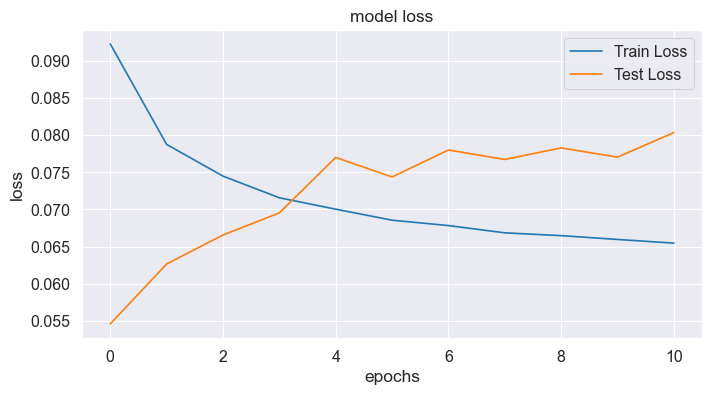

In [47]:

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

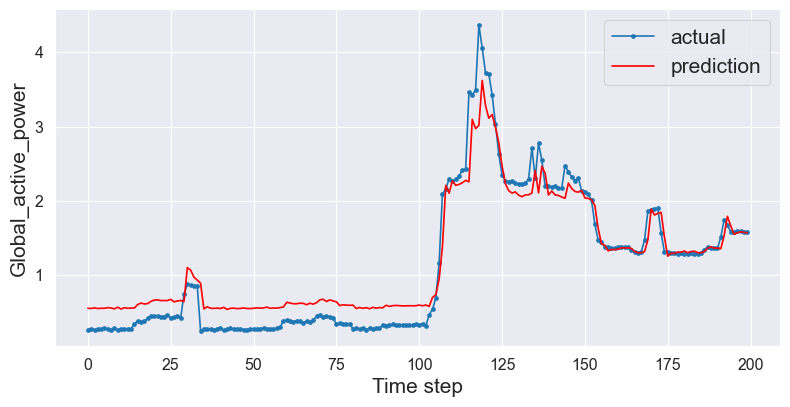

In [48]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();